In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score

In [95]:
data=pd.read_csv("Fraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.shape

(6362620, 11)

In [4]:
data.info

<bound method DataFrame.info of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1

In [5]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
fraud_dist=data["isFraud"].value_counts()

In [10]:
print(fraud_dist)

isFraud
0    6354407
1       8213
Name: count, dtype: int64


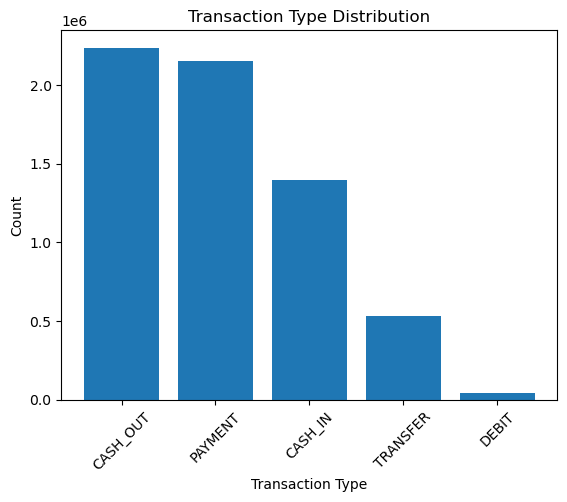

In [11]:
type_counts = data['type'].value_counts()
plt.bar(type_counts.index, type_counts.values)
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.tick_params(axis='x', rotation=45)


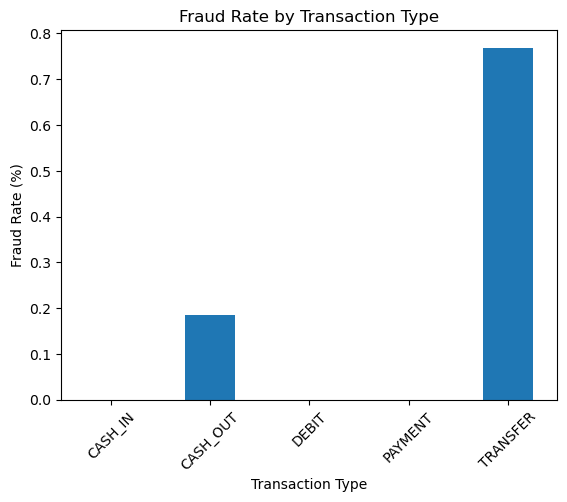

In [12]:
fraud_by_type = data.groupby('type')['isFraud'].agg(['sum', 'count'])
fraud_by_type['fraud_rate'] = fraud_by_type['sum'] / fraud_by_type['count'] * 100
fraud_by_type['fraud_rate'].plot(kind='bar')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate (%)')
plt.tick_params(axis='x', rotation=45)


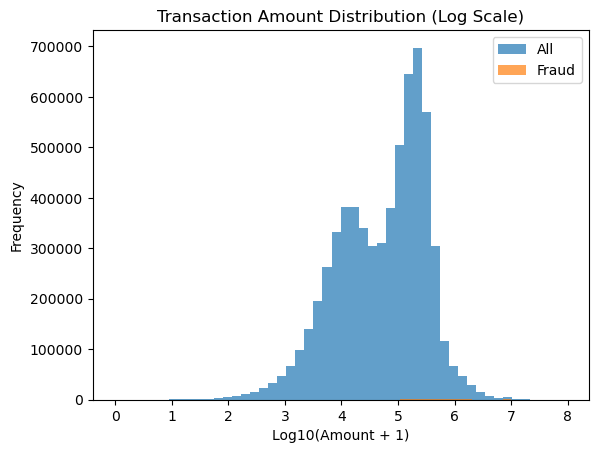

In [13]:

plt.hist(np.log10(data['amount'] + 1), bins=50, alpha=0.7, label='All')
plt.hist(np.log10(data[data['isFraud']==1]['amount'] + 1), bins=50, alpha=0.7, label='Fraud')
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Log10(Amount + 1)')
plt.ylabel('Frequency')
plt.legend()

Text(0, 0.5, 'Number of Fraud Cases')

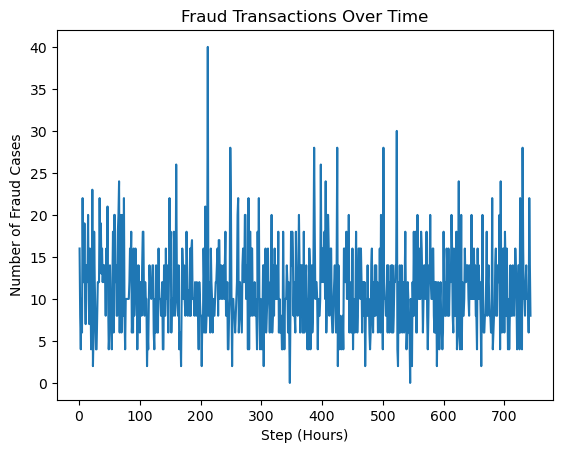

In [31]:
fraud_by_step = data.groupby('step')['isFraud'].sum()
plt.plot(fraud_by_step.index, fraud_by_step.values)
plt.title('Fraud Transactions Over Time')
plt.xlabel('Step (Hours)')
plt.ylabel('Number of Fraud Cases')

Text(0.5, 1.0, 'Correlation Matrix')

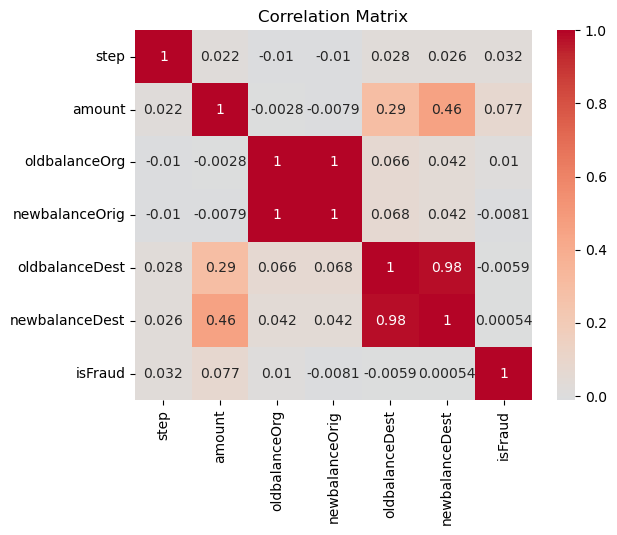

In [32]:
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest', 'isFraud']
corr_matrix = data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

In [39]:
df_features = data.copy()

In [41]:
df_features['balance_diff_orig'] = df_features['oldbalanceOrg'] - df_features['newbalanceOrig']
df_features['balance_diff_dest'] = df_features['newbalanceDest'] - df_features['oldbalanceDest']

In [43]:
df_features['amount_to_old_balance_ratio'] = df_features['amount'] / (df_features['oldbalanceOrg'] + 1)
df_features['amount_to_new_balance_ratio'] = df_features['amount'] / (df_features['newbalanceOrig'] + 1)

In [49]:
le_type = LabelEncoder()
df_features['type_encoded'] = le_type.fit_transform(df_features['type'])


In [51]:
df_features['is_merchant_dest'] = df_features['nameDest'].str.startswith('M').astype(int)
df_features['is_merchant_orig'] = df_features['nameOrig'].str.startswith('M').astype(int)


In [53]:
df_features['zero_old_balance_orig'] = (df_features['oldbalanceOrg'] == 0).astype(int)
df_features['zero_new_balance_orig'] = (df_features['newbalanceOrig'] == 0).astype(int)
df_features['zero_old_balance_dest'] = (df_features['oldbalanceDest'] == 0).astype(int)
df_features['zero_new_balance_dest'] = (df_features['newbalanceDest'] == 0).astype(int)


In [55]:
df_features['is_round_amount'] = (df_features['amount'] % 1 == 0).astype(int)


In [57]:
print("New features created:")
new_features = ['balance_diff_orig', 'balance_diff_dest', 'amount_to_old_balance_ratio',
                'amount_to_new_balance_ratio', 'type_encoded', 'is_merchant_dest',
                'is_merchant_orig', 'zero_old_balance_orig', 'zero_new_balance_orig',
                'zero_old_balance_dest', 'zero_new_balance_dest', 'is_round_amount']
print(new_features)

New features created:
['balance_diff_orig', 'balance_diff_dest', 'amount_to_old_balance_ratio', 'amount_to_new_balance_ratio', 'type_encoded', 'is_merchant_dest', 'is_merchant_orig', 'zero_old_balance_orig', 'zero_new_balance_orig', 'zero_old_balance_dest', 'zero_new_balance_dest', 'is_round_amount']


In [63]:
Q1 = df_features['amount'].quantile(0.25)
Q3 = df_features['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [65]:
outliers = df_features[(df_features['amount'] < lower_bound) | (df_features['amount'] > upper_bound)]
print(f"Outliers in amount (IQR method): {len(outliers)} ({len(outliers)/len(df_features)*100:.2f}%)")

Outliers in amount (IQR method): 338078 (5.31%)


In [67]:
fraud_rate_outliers = outliers['isFraud'].mean()
fraud_rate_normal = df_features[~((df_features['amount'] < lower_bound) | (df_features['amount'] > upper_bound))]['isFraud'].mean()

In [69]:
print(f"Fraud rate in outliers: {fraud_rate_outliers:.4f}")
print(f"Fraud rate in normal transactions: {fraud_rate_normal:.4f}")

Fraud rate in outliers: 0.0114
Fraud rate in normal transactions: 0.0007


In [71]:
feature_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                  'oldbalanceDest', 'newbalanceDest', 'type_encoded',
                  'balance_diff_orig', 'balance_diff_dest', 
                  'amount_to_old_balance_ratio', 'amount_to_new_balance_ratio',
                  'is_merchant_dest', 'is_merchant_orig',
                  'zero_old_balance_orig', 'zero_new_balance_orig',
                  'zero_old_balance_dest', 'zero_new_balance_dest',
                  'is_round_amount']

In [73]:
X = df_features[feature_columns]
y = df_features['isFraud']


In [75]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

In [77]:
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Feature matrix shape: (6362620, 18)
Target distribution: {0: 6354407, 1: 8213}


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [82]:
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (5090096, 18)
Test set size: (1272524, 18)


In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}
model_results = {}


for name, model in models.items():
    print(f"\nTraining {name}...")
    
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_score': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")